In [1]:
import numpy as np
from matplotlib import pyplot as plt
import itertools as it
import math
import pandas as pd
from joblib import Parallel, delayed

In [2]:
#TODO: fix the lateral word inhibition (I think?)

In [123]:
# Parameters
U = 1.0 # Upper bound on activations
L = -0.3 # Lower bound on activations
R = 0 # Resting value of activations
FEATURE_DECAY = 0.01 # Decay rate of activations
PHONEME_DECAY = 0.03 # Decay rate of activations
WORD_DECAY = 0.05 # Decay rate of activations
FEATURE_INHIBITION = 0.04 # Inhibition between features
PHONEME_FEATURE_EXCITATION = 0.00 # Top-down excitation of feature level from the phoneme
FEATURE_PHONEME_EXCITATION = 0.02 # Bottom-up excitation of phoneme level from the features
PHONEME_INHIBITION = 0.08 # Inhibition between phonemes
WORD_INHIBITION = 0.03 # Inhibition between words
PHONEME_WORD_EXCITATION = 0.05 # Bottom-up excitation of word level from the phonemes
WORD_PHONEME_EXCITATION = 0.03 # Top-down excitation of phoneme level from the words

In [140]:
with open('wordlist', 'r') as f:
    KNOWN_WORDS = [line.strip() for line in f.readlines()]
# KNOWN_WORDS = KNOWN_WORDS[:20]
KNOWN_WORDS = ["bar", "aba", "ark", "bark"]
WORD_TO_IND = {word: i for i, word in enumerate(KNOWN_WORDS)} # Mapping from words to indices
WORDS_NUM = len(KNOWN_WORDS) # Number of words in the lexicon

In [141]:
# Input types numpy arrays of floats
def f(a: np.ndarray, net: np.ndarray, D: float) -> np.ndarray:
    """
    Funcation calculting a change in activation.
    :param a: Current activation.
    :param net: Net input to the unit.
    :param D: Decay rate.
    :return: Change in activation.
    """
    assert all([i == j for i, j in zip(a.shape, net.shape)])
    a_f = a.flatten()
    net_f = net.flatten()
    res = np.zeros_like(a_f)
    mask_less = net_f < 0
    ls = (a_f - L) * net_f - D * (a_f - R)
    gt = (U - a_f) * net_f - D * (a_f - R)
    res[mask_less] = ls[mask_less]
    res[~mask_less] = gt[~mask_less]
    return res.reshape(a.shape)

In [142]:
PHONEMES = ['p','b','t','d','k','g','s','S','r','l','a','i','u','^','-']
PHONEMIC_FEATURES = {
    'p' : [4, 1, 7, 2, 8, 1, 8],
    'b' : [4, 1, 7, 2, 8, 7, 7],
    't' : [4, 1, 7, 7, 8, 1, 6],
    'd' : [4, 1, 7, 7, 8, 7, 5],
    'k' : [4, 1, 2, 3, 8, 1, 4],
    'g' : [4, 1, 2, 3, 8, 7, 3],
    's' : [6, 4, 7, 8, 5, 1, 0],
    'S' : [6, 4, 6, 4, 5, 1, 0],
    'r' : [7, 7, 1, 2, 3, 8, 0],
    'l' : [7, 7, 2, 4, 3, 8, 0],
    'a' : [8, 8, 2, 1, 1, 8, 0],
    'i' : [8, 8, 8, 8, 1, 8, 0],
    'u' : [8, 8, 6, 2, 1, 8, 0],
    '^' : [7, 8, 5, 1, 1, 8, 0],
    '-' : [0, 0, 0, 0, 0, 0, 0]
}
PHONEMIC_FEATURES = {k: np.array(v, dtype=int) - 1 for k, v in PHONEMIC_FEATURES.items()}  # Shift features to start from 0

In [143]:
input_string = "bark"  # Input string
slice_num = 11 + 7 * (len(input_string)-1)

In [144]:
slice_num

32

In [145]:
PHONEME_TO_INDEX = {phoneme: i for i, phoneme in enumerate(PHONEMES)}
input_indices = []
i1 = -1
i2 = -1
for i in range(slice_num):
    input_indices.append([])
    if i % 14 == 0: i1 += 1
    if (i-7) % 14 == 0: i2 += 1
    if 14 - (i % 14) > 3 and i1*2 < len(input_string):
        input_indices[-1].append(i1 * 2)
    if i2 >= 0 and 14 - ((i-7) % 14) > 3 and i2*2 + 1 < len(input_string):
        input_indices[-1].append(i2 * 2 + 1)
    

In [146]:
feature_values = np.zeros((slice_num, 7, 8), dtype=np.float64) # (time, dimension, value)
phoneme_values = np.zeros((len(PHONEMES), slice_num // 3 - 1), dtype=np.float64) # (phoneme, number of unit)
word_values = np.zeros((slice_num, WORDS_NUM), dtype=np.float64) # (time, word)

In [147]:
def slice_to_phoneme_unit(slice_idx: int) -> list[int]:
    """
    Function mapping slice index to phoneme unit indices.
    :param slice_idx: Index of the slice.
    :return: List of phoneme unit indices active at this slice.
    """
    inds = []
    if slice_idx // 6 *2 < phoneme_values.shape[1]:
        inds.append(slice_idx // 6 * 2)
    if slice_idx >= 3 and (slice_idx-3) // 6 * 2 + 1 < phoneme_values.shape[1]:
        inds.append((slice_idx-3) // 6 * 2 + 1)
    return inds

def phoneme_unit_to_slice(unit_idx: int) -> int:
    """
    Function mapping phoneme unit index to slice index.
    :param phoneme_idx: Index of the phoneme.
    :param unit_idx: Index of the unit for this phoneme.
    :return: Slice index corresponding to this phoneme unit's centre.
    """
    if unit_idx % 2 == 0:
        return unit_idx // 2 * 6 + 2
    else:
        return (unit_idx // 2) * 6 + 5


In [148]:
def feature_layer_update_delta(feature_values: np.ndarray,
                               phoneme_values: np.ndarray,
                               input_string: str,
                               slice_num_i: int,
                               slice_num: int) -> np.ndarray:
    """
    Function updating feature layer activations for step i.
    :param feature_values: Current feature layer activations.
    :param phoneme_values: Current phoneme layer activations.
    :param input_string: Input string of phonemes.
    :param slice_num_i: Current slice number.
    :param slice_num: Total number of slices.
    :return: Feature layer activations delta for the time slice.
    """
    i = slice_num_i

    # Update feature values
    features_net = np.zeros_like(feature_values)
    # Input excitation
    for ind in input_indices[i]:
        phoneme = input_string[ind]
        features = PHONEMIC_FEATURES[phoneme]

        for f_idx, feature in enumerate(features):
            if feature == -1:
                continue
            features_net[i, f_idx, feature] += 1.0
            
        
    # Lateral inhibition
    for n in range(slice_num):
        for dim1 in range(7):
            for dim2 in range(7):
                if dim1 != dim2:
                    features_net[n, dim1, :] -= FEATURE_INHIBITION * np.clip(feature_values[n, dim2, :], 0, U)
    
    # Top-down excitation from phoneme layer
    for ph_idx in range(len(PHONEMES)):
        for unit_idx in range(phoneme_values.shape[1]):
            unit_centre_slice = phoneme_unit_to_slice(unit_idx)
            window = range(max(unit_centre_slice - 2, 0), min(unit_centre_slice + 4, slice_num))
            for f_idx, feature in enumerate(PHONEMIC_FEATURES[PHONEMES[ph_idx]]):
                if feature == -1:
                    continue
                for i,w in enumerate(window):
                    window_weight = i if w < unit_centre_slice else (len(window) - 1 - i)
                    window_weight /= len(window) // 2
                    features_net[w, f_idx, feature] += PHONEME_FEATURE_EXCITATION * window_weight * np.clip(phoneme_values[ph_idx, unit_idx], 0, U)

    # Update feature activations
    features_delta = f(feature_values, features_net, FEATURE_DECAY)
    return features_delta

In [149]:
def phoneme_layer_update_delta(feature_values: np.ndarray,
                               phoneme_values: np.ndarray,
                               word_values: np.ndarray,
                               slice_num: int) -> np.ndarray:
    """
    Function updating phoneme layer activations for step i.
    :param phoneme_values: Current phoneme layer activations.
    :param feature_values: Current feature layer activations.
    :param slice_num_i: Current slice number.
    :param slice_num: Total number of slices.
    :return: Phoneme layer activations delta for the time slice.
    """
    # Phoneme layer delta calculations
    phoneme_net = np.zeros_like(phoneme_values)
    
    # Bottom-up excitation from feature layer
    for ph_idx in range(len(PHONEMES)):
        for unit_idx in range(phoneme_values.shape[1]):
            unit_centre_slice = phoneme_unit_to_slice(unit_idx)
            window = range(max(unit_centre_slice - 2, 0), min(unit_centre_slice + 4, slice_num))
            for f_idx, feature in enumerate(PHONEMIC_FEATURES[PHONEMES[ph_idx]]):
                if feature == -1:
                    continue
                for i,w in enumerate(window):
                    window_weight = i if w < unit_centre_slice else (len(window) - 1 - i)
                    window_weight /= len(window) // 2
                    phoneme_net[ph_idx, unit_idx] += FEATURE_PHONEME_EXCITATION * window_weight * np.clip(feature_values[w, f_idx, feature], 0, U)
        
    # Lateral inhibition between phoneme units
    for unit_idx1 in range(phoneme_values.shape[1]):
        match unit_idx1:
            case 0:
                for phoneme_idx in range(len(PHONEMES)):
                    phonemes_mask = np.ones(len(PHONEMES), dtype=bool)
                    phonemes_mask[phoneme_idx] = False
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1], 0, U))
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * 0.5 * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1 + 1], 0, U))

            case _ if unit_idx1 == phoneme_values.shape[1] - 1:
                for phoneme_idx in range(len(PHONEMES)):
                    phonemes_mask = np.ones(len(PHONEMES), dtype=bool)
                    phonemes_mask[phoneme_idx] = False
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1], 0, U))
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * 0.5 * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1 - 1], 0, U))

            case _:
                for phoneme_idx in range(len(PHONEMES)):
                    phonemes_mask = np.ones(len(PHONEMES), dtype=bool)
                    phonemes_mask[phoneme_idx] = False
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1], 0, U))
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * 0.5 * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1 - 1], 0, U))
                    phoneme_net[phoneme_idx, unit_idx1] -= PHONEME_INHIBITION * 0.5 * np.sum(np.clip(phoneme_values[phonemes_mask, unit_idx1 + 1], 0, U))

    # Top-down excitation from word layer
    for n in range(slice_num):
        for w in range(WORDS_NUM):
            word = KNOWN_WORDS[w]
            center_slices = [n + 6*i for i in range(len(word))]
            slices = [(i-1, 0.5) for i in center_slices] + [(i, 1) for i in center_slices] + [(i+1, 0.5) for i in center_slices]
            slices = list(filter(lambda x: 0 <= x[0] < slice_num, slices))
            phoneme_units = [slice_to_phoneme_unit(slice[0]) for slice in slices]
            for weight, units, phoneme in zip([slice[1] for slice in slices], phoneme_units, word):
                for unit in units:
                    phoneme_idx = PHONEME_TO_INDEX[phoneme]
                    phoneme_net[phoneme_idx, unit] += WORD_PHONEME_EXCITATION * weight * np.clip(word_values[n, w], 0, U)

    phoneme_delta = f(phoneme_values, phoneme_net, PHONEME_DECAY)

    return phoneme_delta

In [150]:
def word_layer_update_delta(word_values: np.ndarray,
                             phoneme_values: np.ndarray,
                             slice_num: int) -> np.ndarray:
    """
    Function updating word layer activations for step i.
    :param word_values: Current word layer activations.
    :param phoneme_values: Current phoneme layer activations.
    :param slice_num_i: Current slice number.
    :param slice_num: Total number of slices.
    :return: Word layer activations delta for the time slice.
    """
    # Word layer delta calculations
    # Lateral inhibition between words
    for n1 in range(slice_num):
        for w1 in range(WORDS_NUM):
            window_end = min(len(KNOWN_WORDS[w1]) * 6 + n1, slice_num)
            window_start = n1
            for n2 in range(slice_num):
                for w2 in range(WORDS_NUM):
                    if w1 != w2 or n1 != n2:
                        window_end2 = min(len(KNOWN_WORDS[w2]) * 6 + n2, slice_num)
                        window_start2 = n2
                        overlap = max(0, min(window_end, window_end2) - max(window_start, window_start2))
                        overlap_coef = overlap / min(len(KNOWN_WORDS[w1]) * 6, len(KNOWN_WORDS[w2]) * 6)
                        if overlap_coef > 0:
                            word_values[n1, w1] -= WORD_INHIBITION * overlap_coef * np.clip(word_values[n2, w2], 0, U)
    
    # Phoneme to word excitation
    for n in range(slice_num):
        for w in range(WORDS_NUM):
            word = KNOWN_WORDS[w]
            center_slices = [n + 6*i for i in range(len(word))]
            slices = [(i-1, 0.5) for i in center_slices] + [(i, 1) for i in center_slices] + [(i+1, 0.5) for i in center_slices]
            slices = list(filter(lambda x: 0 <= x[0] < slice_num, slices))
            phoneme_units = [slice_to_phoneme_unit(slice[0]) for slice in slices]
            for weight, units, phoneme in zip([slice[1] for slice in slices], phoneme_units, word):
                for unit in units:
                    phoneme_idx = PHONEME_TO_INDEX[phoneme]
                    word_values[n, w] += PHONEME_WORD_EXCITATION * weight * np.clip(phoneme_values[phoneme_idx, unit], 0, U)

    # Update word activations
    word_delta = f(word_values, word_values, WORD_DECAY)
    return word_delta

In [151]:
feature_values_agg = []
phoneme_values_agg = []
word_values_agg = []
for i in range(slice_num):

    # Compute phoneme and word deltas in parallel
    feature_values_delta, phoneme_values_delta, word_values_delta = Parallel(n_jobs=-1)(
        [
            delayed(feature_layer_update_delta)(feature_values, phoneme_values, input_string, i, slice_num),
            delayed(phoneme_layer_update_delta)(feature_values, phoneme_values, word_values, slice_num),
            delayed(word_layer_update_delta)(word_values, phoneme_values, slice_num)
        ]
    )

    word_values_delta = word_layer_update_delta(word_values, phoneme_values, slice_num)

    feature_values += feature_values_delta
    feature_values = np.clip(feature_values, L, U)
    feature_values_agg.append(feature_values.copy())

    phoneme_values += phoneme_values_delta
    phoneme_values = np.clip(phoneme_values, L, U)
    phoneme_values_agg.append(phoneme_values.copy())

    word_values += word_values_delta
    word_values = np.clip(word_values, L, U)
    word_values_agg.append(word_values.copy())
            


Text(0, 0.5, 'Time slices of feature activations')

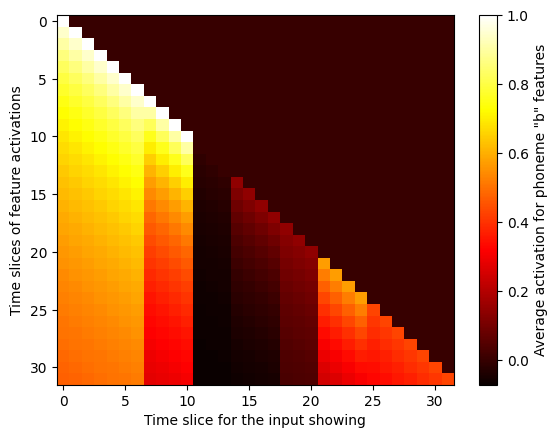

In [152]:
# Make a visualization of feature activations over time, choosing units responding to the first phoneme 'b'
avg_b_responses = np.zeros((slice_num, slice_num), dtype=np.float64)
for t in range(slice_num):
    feature_vals = feature_values_agg[t]
    b_features = PHONEMIC_FEATURES['b']
    response = 0.0
    for f_idx, feature in enumerate(b_features):
        if feature == -1:
            continue
        response += feature_vals[:, f_idx, feature]
    avg_b_responses[t] = response / (7 - np.sum(b_features == -1))
plt.imshow(avg_b_responses, aspect='auto', cmap='hot')
plt.colorbar(label='Average activation for phoneme "b" features')
plt.xlabel('Time slice for the input showing')
plt.ylabel('Time slices of feature activations')


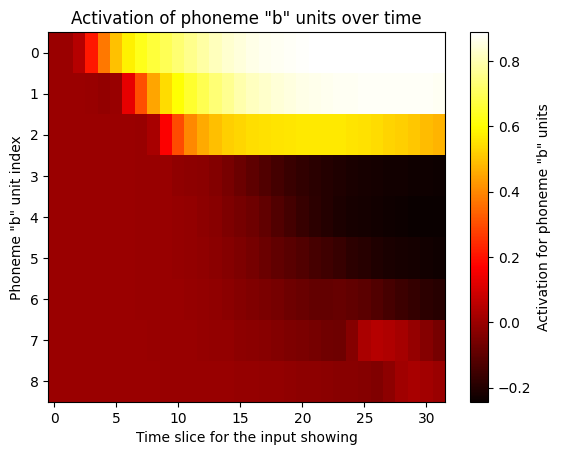

In [153]:
b_phoneme_responses = np.zeros((slice_num, phoneme_values.shape[1]), dtype=np.float64)
for t in range(slice_num):
    phoneme_vals = phoneme_values_agg[t]
    b_phoneme_idx = PHONEMES.index('b')
    b_phoneme_responses[t] = phoneme_vals[b_phoneme_idx]
plt.figure()
plt.imshow(b_phoneme_responses.T, aspect='auto', cmap='hot')
plt.colorbar(label='Activation for phoneme "b" units')
plt.ylabel('Phoneme "b" unit index')
plt.xlabel('Time slice for the input showing')
plt.title('Activation of phoneme "b" units over time')
plt.show()

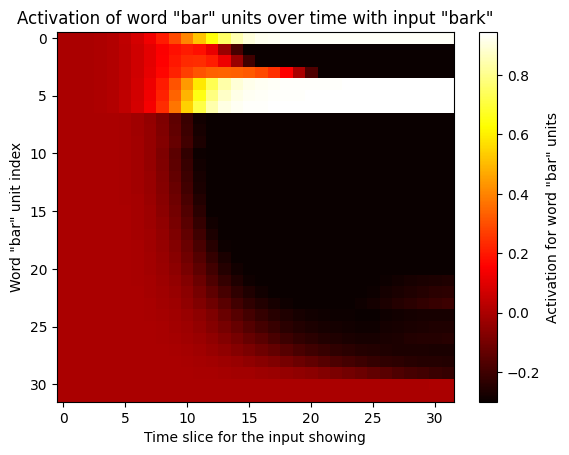

(32,)


,Time,Max Activation Word,Probability
0,0,bark,0.074356
1,1,bar,0.021536
2,2,bar,0.021536
3,3,bark,0.072641
4,4,bark,0.074964
5,5,bark,0.075082
6,6,bark,0.075171
7,7,bar,0.021536
8,8,bark,0.021542
9,9,bark,0.021762


In [154]:
word_responses = np.zeros((slice_num, word_values.shape[0]), dtype=np.float64)
word = "bar"
for t in range(slice_num):
    word_vals = word_values_agg[t]
    word_responses[t] = word_vals[:, WORD_TO_IND[word]]
plt.figure()
plt.imshow(word_responses.T, aspect='auto', cmap='hot')
plt.colorbar(label=f'Activation for word "{word}" units')
plt.ylabel(f'Word "{word}" unit index')
plt.xlabel('Time slice for the input showing')
plt.title(f'Activation of word "{word}" units over time with input "{input_string}"')
plt.show()

max_activation_word_indices = np.argmax(word_values_agg[-1], axis=1)
activations = []
for i in range(slice_num):
    activations.append(word_values_agg[-1][i, max_activation_word_indices[i]])
activations = np.array(activations)
probs = np.exp(activations) / np.sum(np.exp(activations))
print(probs.shape)
words = [KNOWN_WORDS[idx] for idx in max_activation_word_indices]
time = list(range(slice_num))
words_df = pd.DataFrame({'Time': time, 'Max Activation Word': words, 'Probability': probs})
words_df